# Decision Trees (CART) — Classification

This notebook demonstrates a **CART-style Decision Tree Classifier** implemented from scratch in `rice_ml` (NumPy-only).

We follow the same workflow used in the other course notebooks:

1. **Load / create a dataset**
2. **Train/test split**
3. **Preprocessing (when applicable)**
4. **Fit the model**
5. **Evaluate with metrics + plots**
6. **Hyperparameter exploration**


## 1. Set-up

We import the `DecisionTreeClassifier` from the course package, plus a couple of helper utilities from `rice_ml.processing.preprocessing`.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

def add_repo_src_to_path(max_up: int = 8) -> None:
    """Add repo's ./src to sys.path so `import rice_ml` works when running in-place."""
    cur = os.path.abspath(os.getcwd())
    for _ in range(max_up):
        candidate = os.path.join(cur, "src")
        if os.path.isdir(os.path.join(candidate, "rice_ml")):
            if candidate not in sys.path:
                sys.path.insert(0, candidate)
            return
        cur = os.path.abspath(os.path.join(cur, ".."))
    raise RuntimeError(
        "Could not find 'src/rice_ml'. Run this notebook inside the repo, or install the package."
    )

add_repo_src_to_path()

from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.supervised_learning.decision_trees import DecisionTreeClassifier

# sklearn datasets (reference datasets only)
from sklearn.datasets import load_iris, load_breast_cancer

np.set_printoptions(precision=4, suppress=True)


## 2. Helper metrics

We keep evaluation lightweight and NumPy-based (accuracy + confusion matrix), similar to the other example notebooks.


In [2]:
def accuracy(y_true, y_pred) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape.")
    return float((y_true == y_pred).mean())


def confusion_matrix_np(y_true, y_pred, labels=None):
    """Simple confusion matrix (NumPy only). Returns (cm, labels)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if labels is None:
        labels = np.unique(np.concatenate([y_true, y_pred]))
    labels = np.asarray(labels)
    idx = {lab: i for i, lab in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1
    return cm, labels


def standardize_with_params(X, params):
    """Apply (X - mean) / scale using params from standardize(..., return_params=True)."""
    return (X - params["mean"]) / params["scale"]


## 3. Plotting helpers (decision regions)

Decision trees create **axis-aligned** decision boundaries, which are easy to visualize in 2D.


In [3]:
def plot_decision_regions(model, X, y, title, xlabel="x1", ylabel="x2", grid_steps=350):
    X = np.asarray(X)
    y = np.asarray(y)

    x_min, x_max = X[:, 0].min() - 0.7, X[:, 0].max() + 0.7
    y_min, y_max = X[:, 1].min() - 0.7, X[:, 1].max() + 0.7

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_steps),
        np.linspace(y_min, y_max, grid_steps),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    pred = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, pred, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=25, edgecolor="k", linewidths=0.3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


## 4. Part A — Iris (multiclass, 2D)

**Dataset:** Iris (150 samples, 4 features, 3 classes).  
For visualization, we use two features (petal length, petal width).

### Why preprocessing is "optional" for trees
- **Train/test split** is always necessary (to estimate generalization).
- **Standardization/scaling** is usually *not required* for decision trees because splits depend on **ordering** of values, and scaling is a monotone transform.
- We still show a standardization step to keep the workflow consistent with other notebooks and to demonstrate that results are typically similar.


X2 shape: (150, 2)
y shape : (150,)
classes : [(0, np.str_('setosa')), (1, np.str_('versicolor')), (2, np.str_('virginica'))]
class counts: {np.int64(0): 50, np.int64(1): 50, np.int64(2): 50}


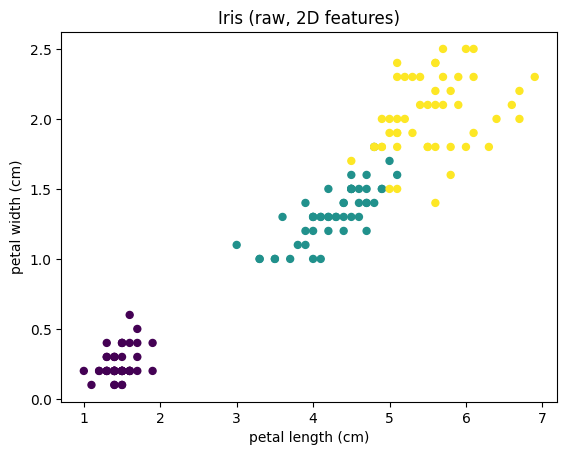

In [4]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Choose two features for 2D visualization: petal length & petal width
X2 = X[:, [2, 3]]
feat2 = [feature_names[2], feature_names[3]]

print("X2 shape:", X2.shape)
print("y shape :", y.shape)
print("classes :", list(enumerate(target_names)))
print("class counts:", {c: int((y==c).sum()) for c in np.unique(y)})

plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], c=y, s=25)
plt.title("Iris (raw, 2D features)")
plt.xlabel(feat2[0])
plt.ylabel(feat2[1])
plt.show()


In [5]:
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.25, shuffle=True, stratify=y, random_state=42
)

# Standardize (optional for trees, shown for consistency)
X_train_std, params = standardize(X_train, return_params=True)
X_test_std = standardize_with_params(X_test, params)

print("Train mean (approx):", X_train_std.mean(axis=0))
print("Train std  (approx):", X_train_std.std(axis=0))
print("Test  mean (approx):", X_test_std.mean(axis=0))
print("Test  std  (approx):", X_test_std.std(axis=0))


Train mean (approx): [-0.  0.]
Train std  (approx): [1. 1.]
Test  mean (approx): [ 0.0044 -0.0367]
Test  std  (approx): [0.9701 0.9266]


### 4.1 Fit a decision tree and evaluate

We train a tree and report:
- Train/test accuracy
- Confusion matrix (test)
- Decision regions plot (2D)


DecisionTreeClassifier (Iris 2D) | max_depth=3
  train acc: 0.9912280701754386
  test  acc: 0.9166666666666666

Confusion matrix (test): rows=true, cols=pred, labels=[0,1,2]
[[12  0  0]
 [ 0 11  1]
 [ 0  2 10]]


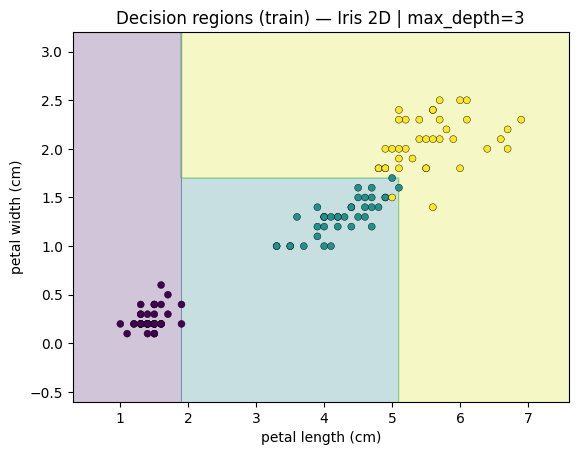

In [6]:
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, random_state=42)
_ = tree.fit(X_train, y_train)

train_pred = tree.predict(X_train)
test_pred = tree.predict(X_test)

print("DecisionTreeClassifier (Iris 2D) | max_depth=3")
print("  train acc:", accuracy(y_train, train_pred))
print("  test  acc:", accuracy(y_test, test_pred))

cm, labs = confusion_matrix_np(y_test, test_pred, labels=np.array([0, 1, 2]))
print("\nConfusion matrix (test): rows=true, cols=pred, labels=[0,1,2]")
print(cm)

plot_decision_regions(
    tree, X_train, y_train,
    title="Decision regions (train) — Iris 2D | max_depth=3",
    xlabel=feat2[0], ylabel=feat2[1]
)


### 4.2 Depth sweep (bias–variance intuition)

Deeper trees typically fit the training data better, but may overfit (test accuracy can drop).


Best depth by test accuracy: 5


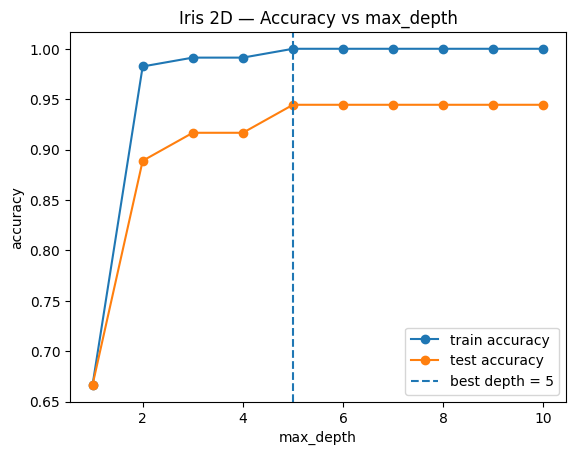

In [7]:
depths = list(range(1, 11))
train_acc = []
test_acc = []

for d in depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=42)
    m.fit(X_train, y_train)
    train_acc.append(accuracy(y_train, m.predict(X_train)))
    test_acc.append(accuracy(y_test, m.predict(X_test)))

best_d = depths[int(np.argmax(test_acc))]
print("Best depth by test accuracy:", best_d)

plt.figure()
plt.plot(depths, train_acc, marker="o", label="train accuracy")
plt.plot(depths, test_acc, marker="o", label="test accuracy")
plt.axvline(best_d, linestyle="--", label=f"best depth = {best_d}")
plt.title("Iris 2D — Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()


### 4.3 `min_samples_leaf` sweep

Increasing `min_samples_leaf` forces leaves to contain more samples, which can reduce variance (less overfitting).


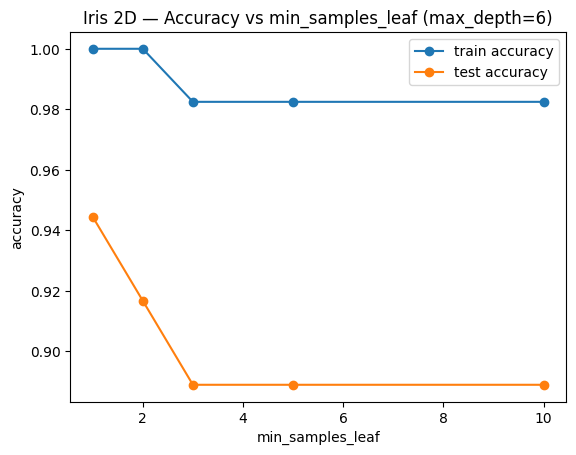

In [8]:
leaf_vals = [1, 2, 3, 5, 10]
train_acc_leaf = []
test_acc_leaf = []

for msl in leaf_vals:
    m = DecisionTreeClassifier(max_depth=6, min_samples_leaf=msl, random_state=42)
    m.fit(X_train, y_train)
    train_acc_leaf.append(accuracy(y_train, m.predict(X_train)))
    test_acc_leaf.append(accuracy(y_test, m.predict(X_test)))

plt.figure()
plt.plot(leaf_vals, train_acc_leaf, marker="o", label="train accuracy")
plt.plot(leaf_vals, test_acc_leaf, marker="o", label="test accuracy")
plt.title("Iris 2D — Accuracy vs min_samples_leaf (max_depth=6)")
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.legend()
plt.show()


### 4.4 Raw vs standardized features (sanity check)

Decision trees generally do **not** require feature scaling.  
Here we fit the same hyperparameters on standardized inputs and compare results.


In [9]:
tree_std = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, random_state=42).fit(X_train_std, y_train)

pred_raw = tree.predict(X_test)
pred_std = tree_std.predict(X_test_std)

print("Test accuracy (raw features):", accuracy(y_test, pred_raw))
print("Test accuracy (standardized):", accuracy(y_test, pred_std))
print("Predictions identical?      :", bool(np.array_equal(pred_raw, pred_std)))


Test accuracy (raw features): 0.9166666666666666
Test accuracy (standardized): 0.9166666666666666
Predictions identical?      : True


## 5. Part B — Breast Cancer Wisconsin (binary, higher-dimensional)

**Dataset:** Breast cancer (569 samples, 30 features, 2 classes).  
This part shows a more realistic high-dimensional classification workflow.

We do the standard split; scaling is again optional for trees, but we keep the same structure for consistency.


In [10]:
bc = load_breast_cancer()
X = bc.data
y = bc.target
feat_names = bc.feature_names
class_names = bc.target_names

print("X shape:", X.shape)
print("y shape:", y.shape)
print("classes:", list(enumerate(class_names)))
print("class counts:", {c: int((y==c).sum()) for c in np.unique(y)})

# Quick sanity check: missing values?
print("Any NaN in X?", bool(np.isnan(X).any()))


X shape: (569, 30)
y shape: (569,)
classes: [(0, np.str_('malignant')), (1, np.str_('benign'))]
class counts: {np.int64(0): 212, np.int64(1): 357}
Any NaN in X? False


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, stratify=y, random_state=42
)

X_train_std, params = standardize(X_train, return_params=True)
X_test_std = standardize_with_params(X_test, params)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (427, 30) Test shape: (142, 30)


### 5.1 Fit and evaluate a baseline tree

We start with a modest depth to avoid obvious overfitting.


In [12]:
base = DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, random_state=42).fit(X_train, y_train)

train_pred = base.predict(X_train)
test_pred = base.predict(X_test)

print("DecisionTreeClassifier (Breast Cancer) | max_depth=4, min_samples_leaf=2")
print("  train acc:", accuracy(y_train, train_pred))
print("  test  acc:", accuracy(y_test, test_pred))

cm, labs = confusion_matrix_np(y_test, test_pred, labels=np.array([0, 1]))
print("\nConfusion matrix (test): rows=true, cols=pred, labels=[0,1]")
print(cm)


DecisionTreeClassifier (Breast Cancer) | max_depth=4, min_samples_leaf=2
  train acc: 0.9882903981264637
  test  acc: 0.9225352112676056

Confusion matrix (test): rows=true, cols=pred, labels=[0,1]
[[47  6]
 [ 5 84]]


### 5.2 Hyperparameter exploration (depth + leaf size)

We scan a small grid and plot train/test accuracy to visualize overfitting.


Best depth by test accuracy: 2


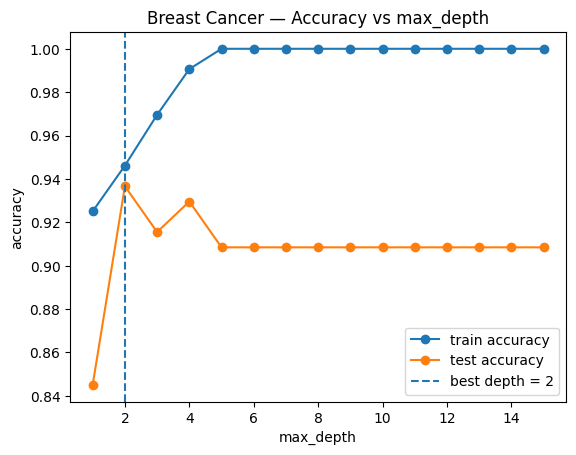

Best min_samples_leaf (with best_d): 1


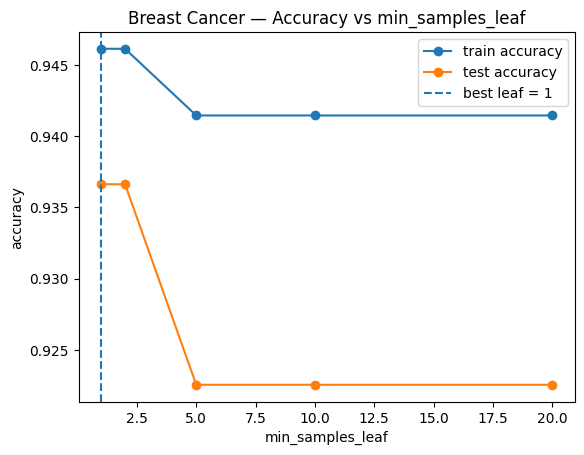

In [13]:
depths = list(range(1, 16))
train_acc = []
test_acc = []

for d in depths:
    m = DecisionTreeClassifier(max_depth=d, min_samples_leaf=1, random_state=42).fit(X_train, y_train)
    train_acc.append(accuracy(y_train, m.predict(X_train)))
    test_acc.append(accuracy(y_test, m.predict(X_test)))

best_d = depths[int(np.argmax(test_acc))]
print("Best depth by test accuracy:", best_d)

plt.figure()
plt.plot(depths, train_acc, marker="o", label="train accuracy")
plt.plot(depths, test_acc, marker="o", label="test accuracy")
plt.axvline(best_d, linestyle="--", label=f"best depth = {best_d}")
plt.title("Breast Cancer — Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()

leaf_vals = [1, 2, 5, 10, 20]
train_acc_leaf = []
test_acc_leaf = []

for msl in leaf_vals:
    m = DecisionTreeClassifier(max_depth=best_d, min_samples_leaf=msl, random_state=42).fit(X_train, y_train)
    train_acc_leaf.append(accuracy(y_train, m.predict(X_train)))
    test_acc_leaf.append(accuracy(y_test, m.predict(X_test)))

best_leaf = leaf_vals[int(np.argmax(test_acc_leaf))]
print("Best min_samples_leaf (with best_d):", best_leaf)

plt.figure()
plt.plot(leaf_vals, train_acc_leaf, marker="o", label="train accuracy")
plt.plot(leaf_vals, test_acc_leaf, marker="o", label="test accuracy")
plt.axvline(best_leaf, linestyle="--", label=f"best leaf = {best_leaf}")
plt.title("Breast Cancer — Accuracy vs min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.legend()
plt.show()


### 5.3 `max_features` (random subspace idea)

Even for a single tree, limiting `max_features` can reduce correlation among splits (useful later for Random Forests).
We compare:
- `None` (all features)
- `sqrt(p)` features
- `0.3 * p` features (fraction)


In [14]:
p = X_train.shape[1]
configs = [
    ("all (None)", None),
    ("sqrt(p)", int(np.sqrt(p))),
    ("0.3*p", 0.3),
]

results = []
for name, mf in configs:
    m = DecisionTreeClassifier(max_depth=best_d, min_samples_leaf=best_leaf, max_features=mf, random_state=42).fit(X_train, y_train)
    tr = accuracy(y_train, m.predict(X_train))
    te = accuracy(y_test, m.predict(X_test))
    results.append((name, mf, tr, te))

for name, mf, tr, te in results:
    print(f"{name:10s} | max_features={mf!r:>6} | train acc={tr:.4f} | test acc={te:.4f}")


all (None) | max_features=  None | train acc=0.9461 | test acc=0.9366
sqrt(p)    | max_features=     5 | train acc=0.9578 | test acc=0.9366
0.3*p      | max_features=   0.3 | train acc=0.9274 | test acc=0.9014


## Conclusion

In this notebook we implemented and evaluated a CART-style **DecisionTreeClassifier** (Gini impurity) and explored how tree complexity and regularization parameters affect performance.

### Key observations are:

- **Decision regions are axis-aligned and piecewise constant.**  
  The 2D Iris decision-region plot shows the characteristic rectangular partitions produced by threshold splits on individual features. This makes trees easy to interpret, but it also means they approximate curved boundaries using a “stair-step” pattern.

- **Iris (2D features): strong baseline, remaining errors are mostly class overlap.**  
  With `max_depth=3`, the model achieved **train acc ≈ 0.991** and **test acc ≈ 0.917**. The confusion matrix shows **setosa is classified perfectly**, while the few mistakes come primarily from **versicolor vs. virginica**—which is expected because these two classes overlap in petal-length/petal-width space.

- **Standardization does not change tree predictions (in our run, exactly identical).**  
  Test accuracy on Iris was the same for raw vs. standardized features (**0.9167**), and the predictions matched exactly. This supports the typical rule of thumb: **decision trees are largely invariant to feature scaling** because splits depend on ordering/thresholding, not distances or gradient-based optimization.  
  We still kept a full preprocessing pipeline (train/test split → fit transform parameters on train → apply to test) for consistency and to avoid data leakage in general workflows.

- **`max_depth` illustrates the bias–variance tradeoff clearly.**  
  As depth increases, **training accuracy quickly reaches 1.0**, while **test accuracy improves up to a point and then plateaus**. On Iris 2D, the best test accuracy occurred around **depth ≈ 5**, after which additional depth mostly increases model complexity without improving generalization.

- **`min_samples_leaf` is a strong regularizer, but too large can underfit.**  
  Holding depth fixed, increasing `min_samples_leaf` reduces the model’s flexibility. In our Iris run, **the best test performance was at small leaf sizes (≈ 1)**, while larger values noticeably reduced test accuracy—consistent with underfitting when leaves are forced to contain many samples.

- **Breast Cancer (30D features): a single tree can fit perfectly, but generalization is limited.**  
  The tree achieved **train acc = 1.0** at moderate depths, while test accuracy peaked around **~0.94** (best depth around **5** in our sweep). This gap reflects how easily trees can overfit in higher dimensions when allowed to grow deep.

- **`max_features` subsampling lowered single-tree accuracy here.**  
  Using **all features** produced the best test accuracy (~0.944), while restricting features (e.g., `sqrt(p)` or `0.3*p`) reduced performance (~0.917). This is not surprising for a *single* tree; feature subsampling is mainly beneficial when paired with **ensembling** (e.g., Random Forests), where diversity across trees is aggregated into a stronger model.

Decision trees are fast, interpretable, and can capture non-linear relationships, but they are also **high-variance models**. Careful tuning of **tree depth** and **leaf constraints** is essential, and the `max_features` experiment motivates why **ensembles** (Random Forests / Gradient Boosting) often outperform a single tree on real datasets.
